In [1]:
import numpy as np
import cv2 as cv
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt 

%matplotlib inline 

# Transform RGB images into grayscale images

In [2]:
from pv_vision.tools import color_conversion

## Here we check the raw RGB image of module

In [3]:
# load all the examples
example_dir = Path('examples')
img_files = os.listdir(example_dir/'transform_seg'/'raw_img_rgb')
if '.DS_Store' in img_files:
    img_files.remove('.DS_Store')

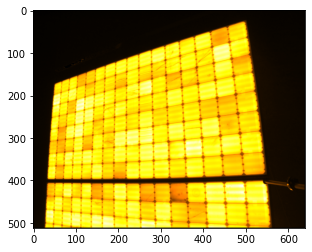

In [4]:
# show one rgb image
img_rgb = cv.imread(str(example_dir/'transform_seg'/'raw_img_rgb'/img_files[0]))
plt.imshow(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB))

In [5]:
# load colormap
colormap = color_conversion.load_colormap(example_dir/'transform_seg'/'colormap.csv',
                                          'Index', ['Red', 'Green', 'Blue'], 0)

((512, 640, 3), (512, 640))

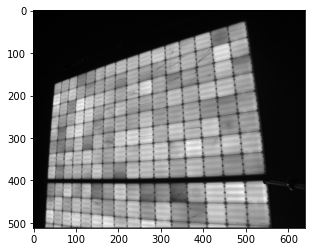

In [6]:
# convert rgb to grayscale
# note that channel order should be RGB. Opencv read images in the order of BGR
img_gray = color_conversion.convert_rgb2gray(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB), colormap)
plt.imshow(img_gray, 'gray')
img_rgb.shape, img_gray.shape


In [7]:
# convert all the images and store
os.makedirs(example_dir/'transform_seg'/'raw_img_gray', exist_ok=True)
for im in tqdm(img_files):
    img_rgb = cv.imread(str(example_dir/'transform_seg'/'raw_img_rgb'/im))
    img_gray = color_conversion.convert_rgb2gray(cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB), colormap)
    cv.imwrite(str(example_dir/'transform_seg'/'raw_img_gray'/im), img_gray)

100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


# Do perspective transform on the raw images

In [8]:
import pv_vision.transform_seg.perspective_transform as transform 

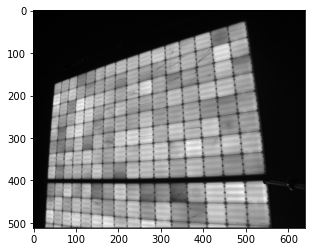

In [9]:
# load the grayscale image
img_files = os.listdir(example_dir/'transform_seg'/'raw_img_gray')
if '.DS_Store' in img_files:
    img_files.remove('.DS_Store')

img_gray = cv.imread(str(example_dir/'transform_seg'/'raw_img_gray'/img_files[0]), cv.IMREAD_UNCHANGED)
plt.imshow(img_gray, 'gray')

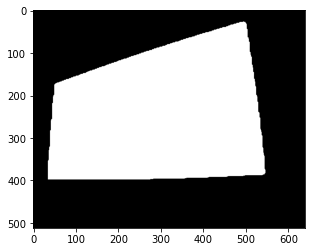

In [10]:
# load mask predicted from UNet
mask, mask_center = transform.load_mask(example_dir/'transform_seg'/'unet_ann'/(img_files[0] + '.json'),
                                        img_gray)
plt.imshow(mask, 'gray')

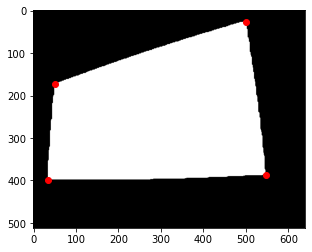

In [11]:
# find corners with method 2
corners = transform.find_module_corner2(mask, mode = 0)
plt.imshow(mask, 'gray')

x, y = zip(*corners)
plt.scatter(x, y, c='r')

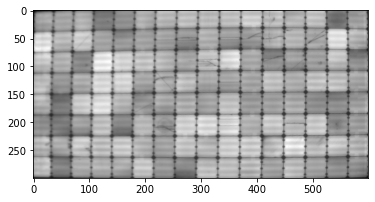

In [12]:
# do perspective transform
img_transformed = transform.perspective_transform(img_gray, corners, 600, 300)
plt.imshow(img_transformed, 'gray')

In [13]:
# do perspective transform on all the images and store in "examples/object_detection/transformed_img". 
# Failures are stored in "examples/object_detection/failed_img"
# here we use combination of transform v1 and v2. Check code document for more details

os.makedirs(example_dir/'object_detection'/'transformed_img', exist_ok=True)
os.makedirs(example_dir/'object_detection'/'failed_img', exist_ok=True)
store_dir = example_dir/'object_detection'/'transformed_img'
err_dir = example_dir/'object_detection'/'failed_img'

N = 0
N_err = 0

for img_file in tqdm(img_files):
    N += 1
    try:
        name = img_file.split('.')[0]
        ann_path = example_dir/'transform_seg'/'unet_ann'/(img_file + '.json')
        image = cv.imread(str(example_dir/'transform_seg'/'raw_img_gray'/img_file), cv.IMREAD_UNCHANGED)

        mask, mask_center = transform.load_mask(ann_path, image)

        flag = True
        try:
            for i in [0, 1]:
                corners = transform.find_module_corner(mask, mask_center, method=i, displace=3)
                wrap = transform.perspective_transform(image, corners, 600, 300)
                peak_x, peak_y = transform.find_inner_edge(wrap)
                # Here we assume that if there are over 12 vertical(should be 15) and 
                # 5 horizontal(should be 7) internal edges, the transform is successful.
                # With current tolerance, about 3 in 900 images that are assumend 
                # transformed are actually failures. This tolerance can be tuned based on your demand
                if len(peak_x) > (16-4) and len(peak_y) > (8-3): 
                    cv.imwrite(str(store_dir/img_file), wrap)
                    flag = False
                    break
        except:
            pass

        
        if flag:
            try:
                for i in [0, 1]:
                    corners = transform.find_module_corner(mask, mask_center, method=i,
                                                        displace=3, corner_center=True, center_displace=50)
                    wrap = transform.perspective_transform(image, corners, 600, 300)
                    peak_x, peak_y = transform.find_inner_edge(wrap)
                    if len(peak_x) > (16-4) and len(peak_y) > (8-3):
                        cv.imwrite(str(store_dir/img_file), wrap)
                        flag = False
                        break
            except:
                pass
        
        if flag:
            try:
                for i in [0, 1, 2, 3]:
                    corners = transform.find_module_corner2(mask, mode=i)
                    wrap = transform.perspective_transform(image, corners, 600, 300)
                    peak_x, peak_y = transform.find_inner_edge(wrap)
                    if len(peak_x) > (16-4) and len(peak_y) > (8-3):
                        cv.imwrite(str(store_dir/img_file), wrap)
                        flag = False
                        break
            except:
                pass                
            
        
        if flag:
            N_err += 1
            with open(err_dir/"error.csv", 'a') as f:
                f.write(name+","+"wrong_peaks\n")
    except:
        N_err += 1
        with open(err_dir/"error.csv", 'a') as f:
            f.write(name+","+"other_errs\n")

print("total images: " + str(N))
print("failed images:" + str(N_err))
print("accuracy: " + str(1-N_err/N))

100%|██████████| 5/5 [00:00<00:00, 44.59it/s]

total images: 5
failed images:0
accuracy: 1.0


# Segment the module images into cells

In [14]:
import pv_vision.transform_seg.cell_crop as seg

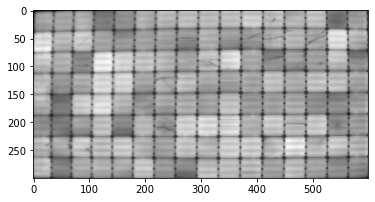

In [15]:
# load the transformed module image
transformed_dir = example_dir/'object_detection'/'transformed_img'
img_files = os.listdir(transformed_dir)

if '.DS_Store' in img_files:
    img_files.remove('.DS_Store')

img_gray = cv.imread(str(transformed_dir/img_files[0]), cv.IMREAD_UNCHANGED)
plt.imshow(img_gray, 'gray')

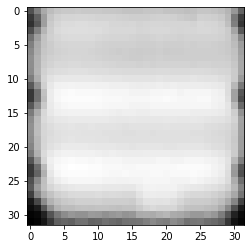

In [16]:
# crop the cells
splits_inx_x, edgelist_x = seg.detect_edge(img_gray, peaks_on=0)
abs_x = seg.linear_regression(splits_inx_x, edgelist_x)
splits_inx_y, edgelist_y = seg.detect_edge(img_gray, peaks_on=1)
abs_y = seg.linear_regression(splits_inx_y, edgelist_y)

abs_x_couple = seg.couple_edges(abs_x, length=600)
abs_y_couple = seg.couple_edges(abs_y, length=300)

# you can pass the cropped cells to single_cells.
# Also you can save the images by setting "save_path" in segment_cell()
single_cells = np.array(seg.segment_cell(img_gray, abs_x_couple, abs_y_couple))
plt.imshow(single_cells[10], 'gray')

In [26]:
# You can also segment the cells and save them into different folders based on their categories.
# You need to have annotations files used to do objective detection

# Here we have five classes in the dataset. We want to save them into different folders
for folder in ['crack', 'solder', 'oxygen', 'intra', 'intact']:
    os.makedirs(example_dir/'cell_classification'/'segmented_cells'/folder, exist_ok=True)
save_path = example_dir/'cell_classification'/'segmented_cells'

# Denote the relation between the label name and folder name
defect2folder = {
    "crack_bbox": "crack",
    "oxygen_bbox": "oxygen",
    "solder_bbox": "solder",
    "intra_bbox": "intra"
}

N = 0
for img_file in tqdm(img_files):
    try:
        name = img_file.split('.')[0]
        image = cv.imread(str(transformed_dir/img_file), cv.IMREAD_UNCHANGED)
        ann_path =  example_dir/'object_detection'/'manual_ann'/(img_file + '.json') # manually annotated

        splits_inx_x, edgelist_x = seg.detect_edge(image, peaks_on=0)
        abs_x = seg.linear_regression(splits_inx_x, edgelist_x)
        splits_inx_y, edgelist_y = seg.detect_edge(image, peaks_on=1)
        abs_y = seg.linear_regression(splits_inx_y, edgelist_y)

        abs_x_couple = seg.couple_edges(abs_x, length=600)
        abs_y_couple = seg.couple_edges(abs_y, length=300)

        single_cells = seg.segment_cell(image, abs_x_couple, abs_y_couple)
        if len(single_cells) != 128:
            N += 1
            with open(save_path/'number_error.csv', 'a') as f:
                f.write(name+'\n')
            continue
        
        # Denote the label names of each class
        defects_dic = {
            'crack_bbox': [],
            'solder_bbox': [],
            'intra_bbox': [],
            'oxygen_bbox': []

        }
        defects_inx = seg.classify_cells(ann_path, defects_dic)
        seg.write_cells(single_cells, defects_inx, defect2folder, name, save_path)
    except:
        N += 1
        with open(save_path/'script_error.csv', 'a') as f:
                f.write(name+'\n')
print(f'fail: {N}, {N / len(img_files)}')

100%|██████████| 5/5 [00:00<00:00, 15.71it/s]

fail: 0, 0.0


# Done!